# Face Recognition - PubFig83

**D3APL – Aplicações em Ciência de dados**

Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 1. Informações Gerais

## 1.1. Conhecendo  o dataset


## 1.2. Atributos:



## 1.3. Objetivo


# 2. Importações
## 2.1 Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import os

# Visualização de imagem
import cv2
import matplotlib.pyplot as plt

## 2.2 Datasets

In [2]:
# Path das imagens
dataset_folder = '../Datasets'
imgs_folder = f'{dataset_folder}/imgs'

# Lista de pastas
class_folders = sorted(os.listdir(imgs_folder))
n_classes = len(class_folders)

print(f'Número de Classes: {n_classes}')

Número de Classes: 83


In [3]:
# Dataset de treino
df_train = pd.read_csv(f'{dataset_folder}/train.csv')

# Dataset de treino
df_test = pd.read_csv(f'{dataset_folder}/test.csv')

print(f'Train: {len(df_train)}')
print(f'Test: {len(df_test)}')

Train: 12178
Test: 1660


## 2.3 Visualização das imagens

In [4]:
def print_image(df, pos, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{df.iloc[pos]["image_pathname"]}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

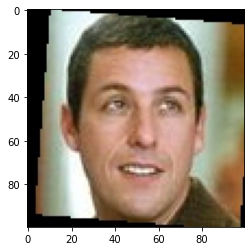

In [5]:
print_image(df_train, 5)

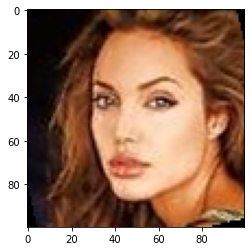

In [6]:
print_image(df_test, 50)

## 2.4 Atributos das imagens

In [7]:
def img_attrs(img_path, dataset_folder=dataset_folder):
    img = cv2.imread(f'{dataset_folder}/{img_path}')
    return [img.shape, (img.min(), img.max())]

In [8]:
attrs = df_train['image_pathname'].apply(img_attrs).apply(pd.Series)
attrs.columns = ['shape', 'colors']

attrs

,shape,colors
0,"(100, 100, 3)","(0, 255)"
1,"(100, 100, 3)","(0, 255)"
2,"(100, 100, 3)","(0, 244)"
3,"(100, 100, 3)","(0, 255)"
4,"(100, 100, 3)","(0, 255)"
...,...,...
12173,"(100, 100, 3)","(0, 236)"
12174,"(100, 100, 3)","(0, 255)"
12175,"(100, 100, 3)","(0, 255)"
12176,"(100, 100, 3)","(0, 255)"


In [9]:
attrs['shape'].unique()

array([(100, 100, 3)], dtype=object)

Todas imagens possuem o mesmo formato, de 100 x 100 x 3

In [10]:
colors_series = attrs['colors'].apply(pd.Series, dtype=np.uint8)
colors_series.min().min(), colors_series.max().max()

(0, 255)

As informações de cores variam de 0 a 255

## 2.5 Distribuição das classes

In [11]:
def images_in_class(cls, imgs_folder=imgs_folder):
    class_path = os.path.join(imgs_folder, cls)
    images = os.listdir(class_path)
    return len(images)

In [12]:
images_dict = { cls: images_in_class(cls) for cls in class_folders }
classes_images = pd.DataFrame.from_dict(images_dict, orient='index', columns=['Images'])
classes_images

,Images
Adam Sandler,108
Alec Baldwin,103
Angelina Jolie,214
Anna Kournikova,171
Ashton Kutcher,101
...,...
Uma Thurman,167
Victoria Beckham,134
Viggo Mortensen,112
Will Smith,128


In [13]:
print(f'Classe com menos imagens: {classes_images.Images.min()} imagens')
print(f'Classe com mais imagens: {classes_images.Images.max()} imagens')

Classe com menos imagens: 100 imagens
Classe com mais imagens: 367 imagens


# 3. Pré-processamento

## 3.1 Preparação dos dados

### 3.1.1 Adição de coluna com as classes nos datasets de treino e teste

In [14]:
df_train['class'] = df_train.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]
df_test['class'] = df_test.loc[:, 'image_pathname'].str.split('/', expand=True).loc[:, 1]

In [15]:
df_train.sample(3)

,image_pathname,class
8833,imgs/Miley Cyrus/1712.jpg,Miley Cyrus
6190,imgs/Joaquin Phoenix/208.jpg,Joaquin Phoenix
2490,imgs/Colin Farrell/153.jpg,Colin Farrell


In [16]:
df_test.sample(3)

,image_pathname,class
104,imgs/Avril Lavigne/357.jpg,Avril Lavigne
1562,imgs/Uma Thurman/28.jpg,Uma Thurman
1257,imgs/Nicole Kidman/291.jpg,Nicole Kidman


### 3.1.2 Criação de um dataset para validação do treinamento

In [17]:
# Dataframe com volume de amostras de treino e teste e a proporção entre eles
samples = pd.concat([df_train['class'].value_counts(), df_test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Test samples']
samples['Proportion'] = samples['Test samples'] / samples['Train samples']
samples

,Train samples,Test samples,Proportion
Miley Cyrus,347,20,0.057637
Lindsay Lohan,334,20,0.059880
Jessica Simpson,280,20,0.071429
Brad Pitt,280,20,0.071429
Avril Lavigne,279,20,0.071685
...,...,...,...
Mariah Carey,82,20,0.243902
Ashton Kutcher,81,20,0.246914
Jack Nicholson,81,20,0.246914
Robert Gates,80,20,0.250000


In [18]:
classes = df_train['class'].unique()
validation = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_validation = df_train[df_train['class'] == cls].sample(20)
    validation = pd.concat([validation, cls_validation])

train = df_train.drop(index=validation.index)

test = df_test

In [19]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Miley Cyrus,327,20,20
Lindsay Lohan,314,20,20
Jessica Simpson,260,20,20
Brad Pitt,260,20,20
Avril Lavigne,259,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


## 3.2 Undersampling dos dados de treinamento

In [20]:
n_desired_samples = 200

In [21]:
classes = df_train['class'].unique()
undersampled = pd.DataFrame(columns=['image_pathname', 'class'])

for cls in classes:
    cls_undersampled = train[train['class'] == cls].sample(frac=1)[:n_desired_samples]
    undersampled = pd.concat([undersampled, cls_undersampled])

train = undersampled

In [22]:
samples = pd.concat([train['class'].value_counts(), validation['class'].value_counts(), test['class'].value_counts()], axis=1)
samples.columns = ['Train samples', 'Validation samples', 'Test samples']
samples

,Train samples,Validation samples,Test samples
Jessica Simpson,200,20,20
Brad Pitt,200,20,20
Gwyneth Paltrow,200,20,20
Daniel Radcliffe,200,20,20
Katherine Heigl,200,20,20
...,...,...,...
Mariah Carey,62,20,20
Ashton Kutcher,61,20,20
Jack Nicholson,61,20,20
Robert Gates,60,20,20


In [23]:
samples.sum()

Train samples         9975
Validation samples    1660
Test samples          1660
dtype: int64

## 3.3 Pré-processamento

Carregamento dos arquivos de imagem e _feature scaling_

In [24]:
import cv2

def preprocess_dataset(dataset_df, label_encoder, dataset_folder=dataset_folder):
    image_list = []
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(f'{dataset_folder}/{img_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        image_list.append(img)
        
        # verbose - print every 1000 iterations
        if index % 1000 == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    X = np.array(image_list)
    
    # feature scaling
    X = X / 255.0
    
    # encoding the classes
    y = label_encoder.fit_transform(dataset_df['class'])
    
    return X, y

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train['class'])

LabelEncoder()

In [26]:
print('Pre-processing the training set:')
X_train, y_train = preprocess_dataset(train, label_encoder)

print('\nPre-processing the validation set:')
X_validation, y_validation = preprocess_dataset(validation, label_encoder)

print('\nPre-processing the test set:')
X_test, y_test = preprocess_dataset(test, label_encoder)

Pre-processing the training set:
1/9975 - imgs/Adam Sandler/196.jpg
1001/9975 - imgs/Beyonce Knowles/409.jpg
2001/9975 - imgs/Clive Owen/128.jpg
3001/9975 - imgs/Denise Richards/198.jpg
4001/9975 - imgs/Halle Berry/367.jpg
5001/9975 - imgs/Jessica Simpson/166.jpg
6001/9975 - imgs/Keira Knightley/361.jpg
7001/9975 - imgs/Michael Bloomberg/228.jpg
8001/9975 - imgs/Reese Witherspoon/306.jpg
9001/9975 - imgs/Silvio Berlusconi/192.jpg

Pre-processing the validation set:
1/1660 - imgs/Adam Sandler/166.jpg
1001/1660 - imgs/Kiefer Sutherland/136.jpg

Pre-processing the test set:
1/1660 - imgs/Adam Sandler/34.jpg
1001/1660 - imgs/Kiefer Sutherland/40.jpg


In [27]:
for name, X, y in [
    ('train', X_train, y_train),
    ('validation', X_validation, y_validation),
    ('test', X_test, y_test)
]:
    print(f'X_{name}.shape: {X.shape}')
    print(f'y_{name}.shape: {y.shape}')
    print(f'y_{name} ({len(np.unique(y))} classes): {np.unique(y)}')
    

    # rescaled 24-bit color image
    print(f'Min. value of X_{name}: {X.min()}')
    print(f'Max. value of X_{name}: {X.max()}\n')

X_train.shape: (9975, 100, 100, 3)
y_train.shape: (9975,)
y_train (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_train: 0.0
Max. value of X_train: 1.0

X_validation.shape: (1660, 100, 100, 3)
y_validation.shape: (1660,)
y_validation (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82]
Min. value of X_validation: 0.0
Max. value of X_validation: 1.0

X_test.shape: (1660, 100, 100, 3)
y_test.shape: (1660,)
y_test (83 classes): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 3

## 3.4 Balanceamento de classes (_data augmentation_)

In [28]:
n_samples = np.bincount(y_train)
classes = np.nonzero(n_samples)[0]

samples_per_class = list(zip(classes, n_samples))
samples_per_class[:5] # Tuples of (class, n_samples)

[(0, 68), (1, 63), (2, 174), (3, 131), (4, 61)]

In [29]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

new_images = []
new_classes = []

# Random number generator
rng = np.random.default_rng()

# Use cpu
with tf.device('/cpu:0'):

    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(factor=0.1, fill_mode='constant'),
        # RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant')
    ])
    
    # For each class
    for (cls, n_samples) in samples_per_class:
        # Indexes of samples of current class
        cls_indexes = np.where(y_train == cls)[0]
        
        # Get n_missing_samples random samples from X_train
        n_missing_samples = n_desired_samples - n_samples

        if n_missing_samples > 0:
            random_indexes = rng.choice(cls_indexes, n_missing_samples)
            imgs = X_train[random_indexes]
        
            # Create new images
            augmented = data_augmentation(imgs)
            new_images.extend(augmented)
            new_classes.extend([cls for _ in range(n_missing_samples)])

Metal device set to: Apple M1


2022-06-22 09:50:13.552001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-22 09:50:13.552090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
arr_new_images = np.array(new_images)
X_train = np.append(X_train, arr_new_images, axis=0)
y_train = np.append(y_train, new_classes)

In [31]:
X_train.shape

(16600, 100, 100, 3)

In [32]:
y_train.shape

(16600,)

Will Smith


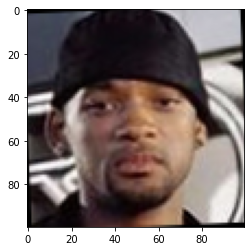

In [33]:
n = 16500
print(label_encoder.classes_[y_train[n]])
plt.imshow(X_train[n])

# 4. Modelos

In [34]:
input_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

In [35]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
def fit_model(model, optimizer, X_train, y_train, X_validation, y_validation):
    loss = 'sparse_categorical_crossentropy'
    metrics = ['accuracy']
    
    early_stopping_patience = 10
    
    epochs = 100
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.summary()
    
    early_stopping_cb = EarlyStopping(
        patience=early_stopping_patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[early_stopping_cb]
    )
    
    return history

In [37]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    
    fig, axes = plt.subplots(2, figsize=(10, 10))

    history_df[['loss', 'val_loss']].plot(ax=axes[0], grid=True)
    history_df[['accuracy', 'val_accuracy']].plot(ax=axes[1], grid=True)

    plt.setp(axes, xticks=range(len(history_df)))
    plt.show()

In [38]:
def print_validation_metrics(model):
    (loss, accuracy) = model.evaluate(X_validation, y_validation)
    print('\nValidation Metrics')
    print('==================\n')
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}\n')

## 4.1 Modelo do zero

Model: "From_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 512)              

2022-06-22 09:50:24.175064: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/519 [..............................] - ETA: 3:51 - loss: 4.4294 - accuracy: 0.0000e+00

2022-06-22 09:50:24.471237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 4.3910 - accuracy: 0.0216

2022-06-22 09:50:42.414802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 19s 36ms/step - loss: 4.3910 - accuracy: 0.0216 - val_loss: 4.3066 - val_accuracy: 0.0434
Epoch 2/100
519/519 [==============================] - 17s 32ms/step - loss: 4.1126 - accuracy: 0.0645 - val_loss: 3.9380 - val_accuracy: 0.0886
Epoch 3/100
519/519 [==============================] - 17s 32ms/step - loss: 3.6961 - accuracy: 0.1287 - val_loss: 3.5782 - val_accuracy: 0.1506
Epoch 4/100
519/519 [==============================] - 17s 32ms/step - loss: 3.2425 - accuracy: 0.2120 - val_loss: 3.1879 - val_accuracy: 0.2301
Epoch 5/100
519/519 [==============================] - 17s 32ms/step - loss: 2.6954 - accuracy: 0.3310 - val_loss: 2.7813 - val_accuracy: 0.3265
Epoch 6/100
519/519 [==============================] - 17s 33ms/step - loss: 2.1554 - accuracy: 0.4556 - val_loss: 2.6492 - val_accuracy: 0.3422
Epoch 7/100
519/519 [==============================] - 17s 32ms/step - loss: 1.6635 - accuracy: 0.5659 - val_loss: 2.4746 - val_accuracy: 0.41

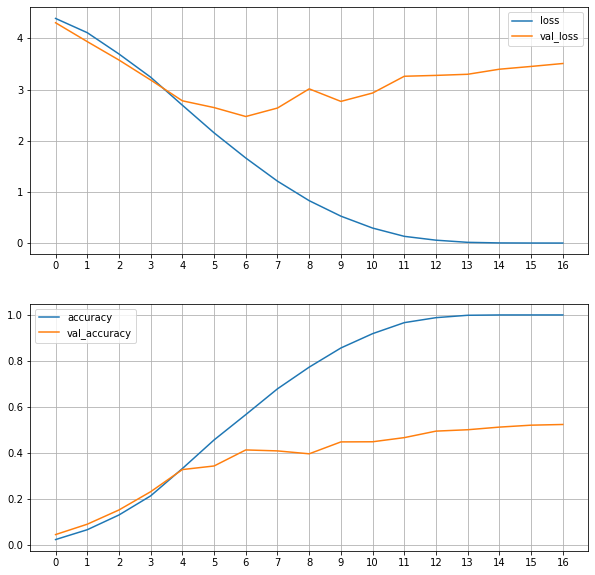

52/52 [==============================] - 1s 12ms/step - loss: 2.4746 - accuracy: 0.4120

Validation Metrics

Loss: 2.4745867252349854
Accuracy: 0.41204819083213806

CPU times: user 55.2 s, sys: 1min 1s, total: 1min 57s
Wall time: 4min 55s


In [39]:
%%time

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD

model_from_scratch = Sequential([
    Conv2D(filters=32, kernel_size=(4,4), input_shape=input_shape, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="From_Scratch")

history = fit_model(
    model=model_from_scratch,
    optimizer=SGD(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_from_scratch)

## 4.2 Utilizando uma arquitetura pré-definida (ResNet50 + NAdam)

Model: "ResNet50_without_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 83)                42579     
                                                                 
Total params: 40,933,331
Trainable params:

2022-06-22 09:55:30.273910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 3.4660 - accuracy: 0.1404

2022-06-22 10:00:11.140676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 294s 521ms/step - loss: 3.4660 - accuracy: 0.1404 - val_loss: 4.5215 - val_accuracy: 0.0127
Epoch 2/100
519/519 [==============================] - 301s 580ms/step - loss: 2.2049 - accuracy: 0.4007 - val_loss: 4.5222 - val_accuracy: 0.1247
Epoch 3/100
519/519 [==============================] - 306s 588ms/step - loss: 1.4882 - accuracy: 0.5827 - val_loss: 2.4727 - val_accuracy: 0.4313
Epoch 4/100
519/519 [==============================] - 306s 589ms/step - loss: 1.0796 - accuracy: 0.6954 - val_loss: 2.0025 - val_accuracy: 0.4910
Epoch 5/100
519/519 [==============================] - 309s 596ms/step - loss: 0.7757 - accuracy: 0.7793 - val_loss: 2.9149 - val_accuracy: 0.4036
Epoch 6/100
519/519 [==============================] - 300s 578ms/step - loss: 0.5782 - accuracy: 0.8317 - val_loss: 1.9983 - val_accuracy: 0.5458
Epoch 7/100
519/519 [==============================] - 290s 558ms/step - loss: 0.4883 - accuracy: 0.8563 - val_loss: 2.0006 - val_

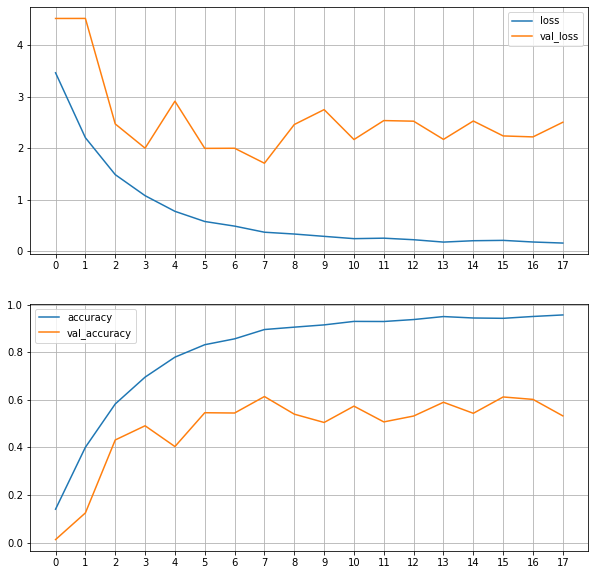

52/52 [==============================] - 6s 111ms/step - loss: 1.7097 - accuracy: 0.6139

Validation Metrics

Loss: 1.7097042798995972
Accuracy: 0.6138554215431213

CPU times: user 43min 26s, sys: 21min 7s, total: 1h 4min 34s
Wall time: 1h 32min 51s


In [40]:
%%time

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(
    include_top=False,
    input_shape=input_shape
)

model_resnet50 = Sequential([
    base_model_resnet50,

    Flatten(),

    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="ResNet50_without_weights")


history = fit_model(
    model=model_resnet50,
    optimizer=Nadam(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_resnet50)

## 4.3 Transfer learning (VGG16 + Adam)

Model: "VGG16_with_imagenet_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 83)                21331     
                                                                 
Total params: 15,981,715
Trainable params: 1,267,027
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100


2022-06-22 11:28:33.597123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 3.4575 - accuracy: 0.1543

2022-06-22 11:30:10.763443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 109s 197ms/step - loss: 3.4575 - accuracy: 0.1543 - val_loss: 2.8950 - val_accuracy: 0.2602
Epoch 2/100
519/519 [==============================] - 107s 207ms/step - loss: 2.4108 - accuracy: 0.3614 - val_loss: 2.5667 - val_accuracy: 0.3488
Epoch 3/100
519/519 [==============================] - 109s 210ms/step - loss: 1.8928 - accuracy: 0.4837 - val_loss: 2.4985 - val_accuracy: 0.3663
Epoch 4/100
519/519 [==============================] - 108s 209ms/step - loss: 1.5224 - accuracy: 0.5789 - val_loss: 2.4058 - val_accuracy: 0.4108
Epoch 5/100
519/519 [==============================] - 109s 210ms/step - loss: 1.2311 - accuracy: 0.6574 - val_loss: 2.4565 - val_accuracy: 0.4133
Epoch 6/100
519/519 [==============================] - 112s 215ms/step - loss: 1.0084 - accuracy: 0.7110 - val_loss: 2.4340 - val_accuracy: 0.4416
Epoch 7/100
519/519 [==============================] - 110s 212ms/step - loss: 0.8186 - accuracy: 0.7631 - val_loss: 2.7204 - val_

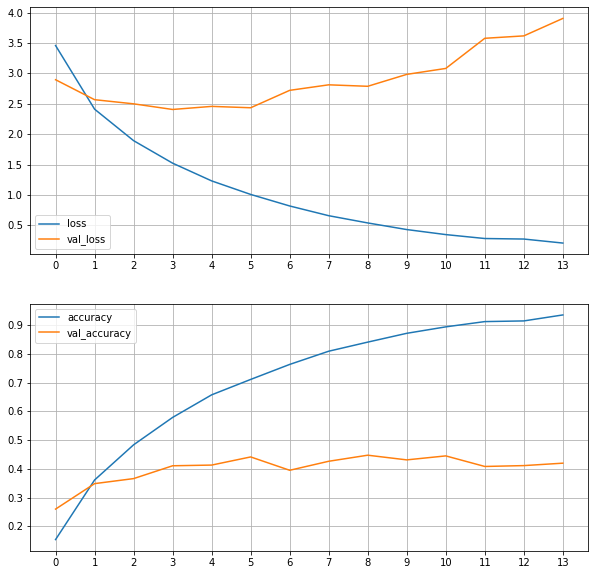

52/52 [==============================] - 9s 164ms/step - loss: 2.4058 - accuracy: 0.4108

Validation Metrics

Loss: 2.405831813812256
Accuracy: 0.4108433723449707

CPU times: user 2min 11s, sys: 5min 13s, total: 7min 24s
Wall time: 25min 41s


In [41]:
%%time

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

base_model_vgg16_imagenet = VGG16(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg16_imagenet.trainable = False

model_vgg16_imagenet = Sequential([
    base_model_vgg16_imagenet,

    Flatten(),

    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="VGG16_with_imagenet_weights")

history = fit_model(
    model=model_vgg16_imagenet,
    optimizer=Adam(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_vgg16_imagenet)

Model: "VGG16_with_imagenet_weights"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              4719616   
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 102

2022-06-22 11:54:09.658991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - ETA: 0s - loss: 4.0712 - accuracy: 0.0234

2022-06-22 11:55:51.625353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


519/519 [==============================] - 114s 218ms/step - loss: 4.0712 - accuracy: 0.0234 - val_loss: 3.9684 - val_accuracy: 0.0223
Epoch 2/100
519/519 [==============================] - 117s 225ms/step - loss: 3.8094 - accuracy: 0.0370 - val_loss: 3.7491 - val_accuracy: 0.0476
Epoch 3/100
519/519 [==============================] - 113s 217ms/step - loss: 3.6801 - accuracy: 0.0485 - val_loss: 3.6856 - val_accuracy: 0.0542
Epoch 4/100
519/519 [==============================] - 111s 214ms/step - loss: 3.5199 - accuracy: 0.0669 - val_loss: 3.6258 - val_accuracy: 0.0735
Epoch 5/100
519/519 [==============================] - 124s 238ms/step - loss: 3.3890 - accuracy: 0.0871 - val_loss: 3.7712 - val_accuracy: 0.0747
Epoch 6/100
519/519 [==============================] - 120s 231ms/step - loss: 3.2799 - accuracy: 0.1080 - val_loss: 3.4544 - val_accuracy: 0.1006
Epoch 7/100
519/519 [==============================] - 116s 224ms/step - loss: 3.1509 - accuracy: 0.1388 - val_loss: 3.3282 - val_

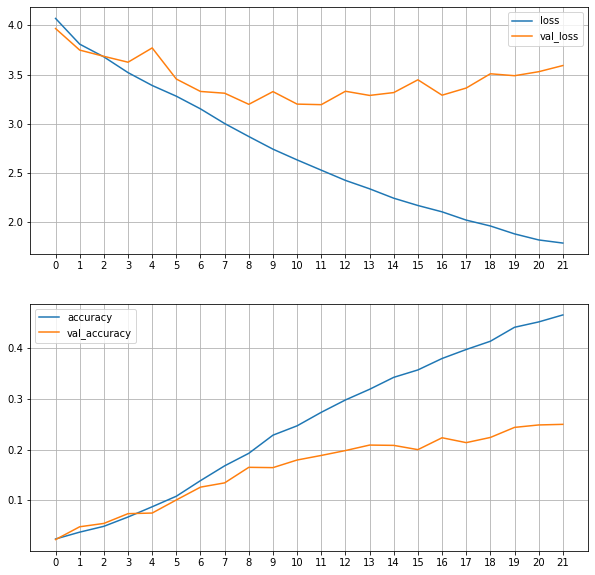

52/52 [==============================] - 10s 186ms/step - loss: 3.1938 - accuracy: 0.1886

Validation Metrics

Loss: 3.193838596343994
Accuracy: 0.18855422735214233

CPU times: user 3min 52s, sys: 8min 15s, total: 12min 7s
Wall time: 41min 59s


In [42]:
%%time

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

base_model_vgg16_imagenet_2 = VGG16(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg16_imagenet_2.trainable = False

model_vgg16_imagenet_2 = Sequential([
    base_model_vgg16_imagenet_2,

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(n_classes, activation='softmax')
], name="VGG16_with_imagenet_weights")

history = fit_model(
    model=model_vgg16_imagenet_2,
    optimizer=Adam(),
    X_train=X_train,
    y_train=y_train,
    X_validation=X_validation,
    y_validation=y_validation
)

plot_history(history)

print_validation_metrics(model_vgg16_imagenet_2)

## 4.4 Extração de features com VGG19 + SVM

In [43]:
%%time

from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG19

base_model_vgg19_imagenet = VGG19(
    include_top=None,
    weights="imagenet",
    input_shape=input_shape
)
base_model_vgg19_imagenet.trainable = False

model_vgg19_imagenet = Sequential([
    base_model_vgg19_imagenet,
    Flatten()
], name="VGG19_Feat_Extractor")

X_train_extracted = model_vgg19_imagenet.predict(X_train)
X_validation_extracted = model_vgg19_imagenet.predict(X_validation)

2022-06-22 12:36:11.461202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 10s 198ms/step
CPU times: user 9.41 s, sys: 26.5 s, total: 35.9 s
Wall time: 2min 30s


In [44]:
%%time

from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

svm = LinearSVC(C=0.01, verbose=1000)
svm.fit(X_train_extracted, y_train)

y_validation_pred = svm.predict(X_validation_extracted)

print(classification_report(y_validation, y_validation_pred, output_dict=True)['accuracy'])

[LibLinear]
systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

..............................*
optimization finished, #iter = 306
Objective value = -2.367546
nSV = 1077
.............................*.**
optimization finished, #iter = 304
Objective value = -2.137975
nSV = 977
...............................**
optimization finished, #iter = 318
Objective value = -3.586972
nSV = 1566
.................................*
optimization finished, #iter = 332
Objective value = -3.615337
nSV = 1552
...............................*.*
optimization finished, #iter = 322
Objective value = -2.471948
nSV = 1168
.............................**.**
optimization finished, #iter = 304
Objective value = -1.957320
nSV = 797
..............................*
optimization finished, #iter = 301
Objective value = -1.761557
nSV = 829
...............................*
optimization finished, #iter = 311
Objective value = -3.100878
nSV = 1402
.................................**
optimization finished, #iter = 336
Objective va

In [45]:
%%time

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_extracted, y_train)

y_validation_pred = rfc.predict(X_validation_extracted)

print(classification_report(y_validation, y_validation_pred, output_dict=True)['accuracy'])

0.23313253012048193
CPU times: user 1min 34s, sys: 1.11 s, total: 1min 36s
Wall time: 1min 35s


# 5. Testes

In [46]:
from sklearn.metrics import classification_report

class_names = label_encoder.classes_

## 5.1 Modelo do zero

In [47]:
model_from_scratch.evaluate(X_test, y_test)

52/52 [==============================] - 1s 15ms/step - loss: 2.5064 - accuracy: 0.4078


[2.5063893795013428, 0.4078313410282135]

In [48]:
y_test_proba = model_from_scratch.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

 6/52 [==>...........................] - ETA: 0s

2022-06-22 12:42:38.702445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 1s 12ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.40      0.20      0.27        20
        Alec Baldwin       0.53      0.50      0.51        20
      Angelina Jolie       0.40      0.30      0.34        20
     Anna Kournikova       0.23      0.30      0.26        20
      Ashton Kutcher       0.40      0.20      0.27        20
       Avril Lavigne       0.45      0.45      0.45        20
        Barack Obama       0.70      0.70      0.70        20
         Ben Affleck       0.25      0.15      0.19        20
     Beyonce Knowles       0.62      0.25      0.36        20
           Brad Pitt       0.03      0.05      0.04        20
        Cameron Diaz       0.23      0.40      0.29        20
      Cate Blanchett       0.18      0.10      0.13        20
     Charlize Theron       0.56      0.25      0.34        20
     Christina Ricci       0.43      0.15      0.22        20
    Claudia Sch

## 5.2 ResNet50

In [49]:
model_resnet50.evaluate(X_test, y_test)

52/52 [==============================] - 6s 97ms/step - loss: 1.7431 - accuracy: 0.6127


[1.7431433200836182, 0.6126506328582764]

In [50]:
y_test_proba = model_resnet50.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

2022-06-22 12:42:45.941804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 7s 98ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.75      0.60      0.67        20
        Alec Baldwin       0.70      0.70      0.70        20
      Angelina Jolie       1.00      0.10      0.18        20
     Anna Kournikova       0.43      0.65      0.52        20
      Ashton Kutcher       0.58      0.55      0.56        20
       Avril Lavigne       0.75      0.75      0.75        20
        Barack Obama       0.66      0.95      0.78        20
         Ben Affleck       0.75      0.60      0.67        20
     Beyonce Knowles       0.48      0.70      0.57        20
           Brad Pitt       0.33      0.70      0.45        20
        Cameron Diaz       0.71      0.50      0.59        20
      Cate Blanchett       0.88      0.35      0.50        20
     Charlize Theron       0.50      0.50      0.50        20
     Christina Ricci       0.71      0.75      0.73        20
    Claudia Sch

## 5.3 VGG16 + imagenet

In [51]:
model_vgg16_imagenet.evaluate(X_test, y_test)

52/52 [==============================] - 7s 128ms/step - loss: 2.4063 - accuracy: 0.4006


[2.406317710876465, 0.40060243010520935]

In [52]:
model_vgg16_imagenet_2.evaluate(X_test, y_test)

52/52 [==============================] - 7s 128ms/step - loss: 3.2242 - accuracy: 0.1982


[3.2241673469543457, 0.1981927752494812]

In [53]:
y_test_proba = model_vgg16_imagenet.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

2022-06-22 12:43:06.414212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 7s 141ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.69      0.45      0.55        20
        Alec Baldwin       0.53      0.45      0.49        20
      Angelina Jolie       0.21      0.30      0.25        20
     Anna Kournikova       0.25      0.25      0.25        20
      Ashton Kutcher       0.67      0.30      0.41        20
       Avril Lavigne       0.32      0.60      0.42        20
        Barack Obama       0.39      0.85      0.53        20
         Ben Affleck       0.45      0.45      0.45        20
     Beyonce Knowles       0.32      0.45      0.38        20
           Brad Pitt       0.32      0.30      0.31        20
        Cameron Diaz       1.00      0.10      0.18        20
      Cate Blanchett       0.18      0.15      0.16        20
     Charlize Theron       0.27      0.35      0.30        20
     Christina Ricci       0.60      0.15      0.24        20
    Claudia Sc

## 5.4 VGG19 + SVM

In [54]:
X_test_extracted = model_vgg19_imagenet.predict(X_test)
y_test_pred = svm.predict(X_test_extracted)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

52/52 [==============================] - 8s 150ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.58      0.70      0.64        20
        Alec Baldwin       0.61      0.55      0.58        20
      Angelina Jolie       0.32      0.45      0.38        20
     Anna Kournikova       0.37      0.35      0.36        20
      Ashton Kutcher       0.50      0.30      0.37        20
       Avril Lavigne       0.64      0.90      0.75        20
        Barack Obama       0.54      0.75      0.63        20
         Ben Affleck       0.50      0.25      0.33        20
     Beyonce Knowles       0.29      0.35      0.32        20
           Brad Pitt       0.28      0.35      0.31        20
        Cameron Diaz       0.33      0.40      0.36        20
      Cate Blanchett       0.24      0.30      0.27        20
     Charlize Theron       0.24      0.30      0.27        20
     Christina Ricci       0.42      0.40      0.41        20
    Claudia Sc

In [55]:
X_test_extracted = model_vgg19_imagenet.predict(X_test)
y_test_pred = rfc.predict(X_test_extracted)
print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

52/52 [==============================] - 8s 154ms/step
                      precision    recall  f1-score   support

        Adam Sandler       0.32      0.35      0.33        20
        Alec Baldwin       0.25      0.40      0.31        20
      Angelina Jolie       0.13      0.25      0.17        20
     Anna Kournikova       0.00      0.00      0.00        20
      Ashton Kutcher       0.08      0.05      0.06        20
       Avril Lavigne       0.26      0.70      0.38        20
        Barack Obama       0.24      0.55      0.33        20
         Ben Affleck       0.06      0.05      0.06        20
     Beyonce Knowles       0.15      0.20      0.17        20
           Brad Pitt       0.09      0.15      0.12        20
        Cameron Diaz       0.21      0.30      0.25        20
      Cate Blanchett       0.13      0.10      0.11        20
     Charlize Theron       0.06      0.05      0.05        20
     Christina Ricci       0.12      0.10      0.11        20
    Claudia Sc